In [1]:
import os
os.chdir('..')

In [2]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from src.data import extract, transform, load
from src.models import embedding as embedding_model, utils as model_utils
from src.models import clustering
from src.tools.startup import settings
from src.tools import utils as tools_utils
from src.visualization import data_plots
import tensorflow as tf
from tensorboard.plugins import projector

import pandas as pd
pd.options.mode.chained_assignment = None

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-2m4l7lf0 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


2023-11-09 11:51:22 - INFO - startup.py - initialize_logger: Logger initialized


2023-11-09 11:51:23.443841: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-09 11:51:23.483708: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-09 11:51:23.484391: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-09 11:51:24.205695: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
There was a problem when trying to write in you

In [3]:
os.environ['SENTENCE_TRANSFORMERS_HOME'] = './.cache'

## Constants

In [4]:
# Folders
interim_folder = os.path.join(settings['volumes']['interim'])
logs_folder = os.path.join(settings['volumes']['logs'], 'embeddings')
processed_folder = os.path.join(settings['volumes']['processed'])

# Multilingual
multilingual = embedding_model.EmbeddingType.multilingual.value
muse_languages = settings['embeddings']['muse']['languages']

multilingual_transformer = embedding_model.EmbeddingType.multilingual_transformer.value

# Separate languages
separate_languages = embedding_model.EmbeddingType.separate_languages.value
spacy_languages = settings['embeddings']['spacy']['languages']

# TF-IDF method
tfidf_by_language = embedding_model.TfidfMethod.by_language.value

max_clusters = 10
random_seed = 90

## Parameters

In [5]:
filenames = [
    os.path.join(interim_folder, 'ocrs', 'all_words_bloc1.json'),
    os.path.join(interim_folder, 'ocrs', 'all_words_bloc2.json'),
    os.path.join(interim_folder, 'ocrs', 'all_words_bloc2_Revista.json'),
    os.path.join(interim_folder, 'ocrs', 'all_words_bloc2_Revista nova.json')
]

filenames = [
    os.path.join(processed_folder, 'all_words_bloc1_corrected.json'),
    os.path.join(processed_folder, 'all_words_bloc2_corrected.json'),
]

folders = [
    os.path.join(processed_folder, 'bloc1_processed'),
    os.path.join(processed_folder, 'bloc2_processed')
]

## Extract

In [6]:
multilingual_corpus_df = extract.read_processed_ocrs(
    muse_languages, filenames)
sep_lang_corpus_df = extract.read_processed_ocrs(
    spacy_languages, filenames)

multilingual_transformer_df = extract.read_processed_ocr_full_text(folders)

## Transform

In [7]:
multilingual_corpus_df.fillna('', inplace=True)
sep_lang_corpus_df.fillna('', inplace=True)
multilingual_transformer_df.fillna('', inplace=True)

### Metadata

### Compute document embeddings

#### Multilingual

In [9]:
multilingual_embedder = embedding_model.Embedder(
    multilingual_corpus_df, 
    embedding_type=multilingual, 
    weight_by_tfidf=True, 
    tfidf_method=tfidf_by_language)

multilingual_embedder.compute_doc_embeddings()

#### Separate languages

In [10]:
sep_lang_embedder = embedding_model.Embedder(
    sep_lang_corpus_df, 
    embedding_type=separate_languages,
    weight_by_tfidf=False, 
    tfidf_method=tfidf_by_language, 
    text_type='processed')

sep_lang_embedder.compute_doc_embeddings()

#### Multilingual transformer

In [11]:
multi_transformer_embedder = embedding_model.Embedder(
    multilingual_transformer_df, 
    embedding_type=multilingual_transformer,
    clean_texts=False)

multi_transformer_embedder.compute_doc_embeddings()

2023-11-09 11:51:28 - INFO - embedding.py - __init__: Device: cpu
2023-11-09 11:51:28 - INFO - embedding.py - __init__: Running embedding type 'multilingual_transformer'...
2023-11-09 11:51:28 - INFO - embedding.py - _compute_multilingual_transformer: Generating chunks from text...
2023-11-09 11:51:28 - INFO - embedding.py - _compute_multilingual_transformer: Done.


No sentence-transformers model found with name ./.cache/bert-base-multilingual-cased. Creating a new one with MEAN pooling.
Computing embeddings: 946it [00:04, 194.18it/s]


### Clustering

In [18]:
sample = list(multi_transformer_embedder.embeddings.items())
sample_doc_ids = np.array([x[0] for x in sample])
sample_embeddings = np.array([x[1] for x in sample])

reduced_data_2d = transform.tsne_transformation(
    sample_embeddings, n_components=2, random_state=random_seed)
reduced_data_3d = transform.tsne_transformation(
    sample_embeddings, n_components=3, random_state=random_seed)

Fitting clustering model: 100%|██████████| 9/9 [00:01<00:00,  5.44it/s, k=10]

2023-11-09 11:52:06 - INFO - clustering.py - perform_clustering: Optimal k is 2
2023-11-09 11:52:06 - INFO - clustering.py - perform_clustering: Scores of optimal k:
{'Silhouette Score': 0.48676214, 'Davis-Bouldin Score': 0.9242042642632853, 'Calinski and Harabasz Score': 627.7576767205113}


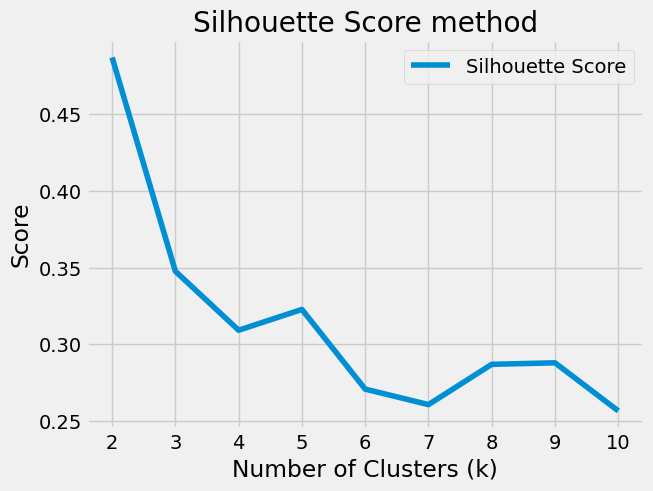

In [16]:
clusters, labels, scores, optimal_k = clustering.perform_clustering(
    sample_embeddings, max_clusters=max_clusters, random_state=random_seed)
data_plots.generate_clustering_scores_plot(
    max_clusters, scores)

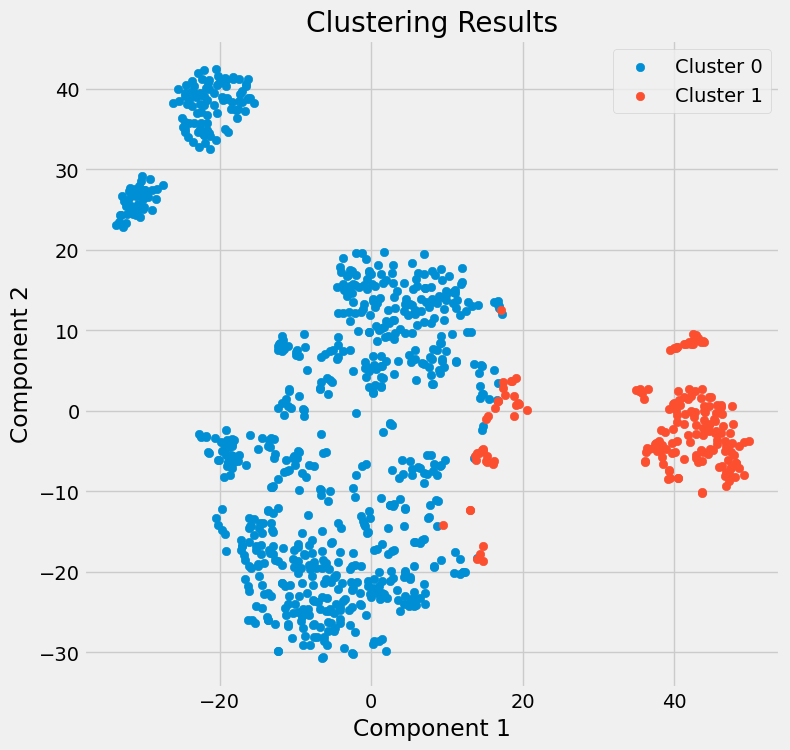

In [17]:
data_plots.plot_clusters(clusters, reduced_data_2d)

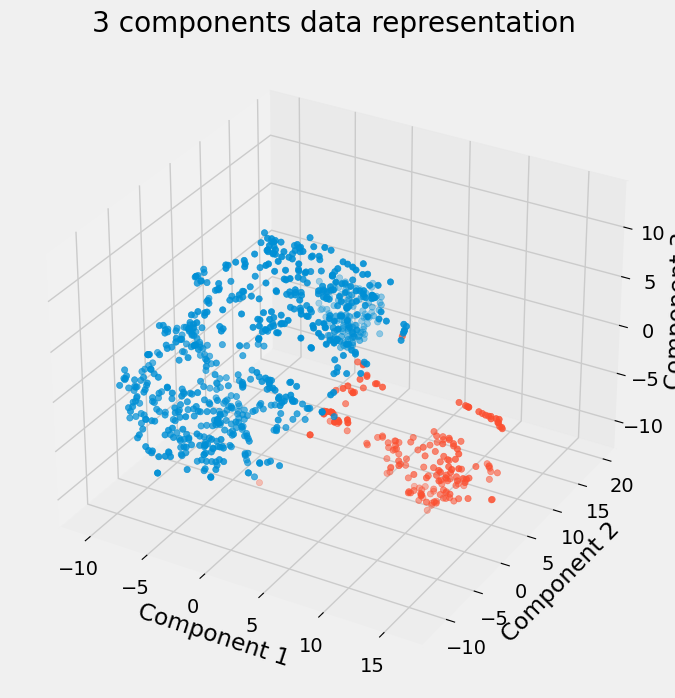

In [19]:
data_plots.plot_clusters(clusters, reduced_data_3d)

## Tensorboard

#### Prepare data for Tensorboard

In [ ]:
# Multilingual
embeddings, doc_ids = [], []
for doc_id, doc_embedding in multilingual_embedder.embeddings.items():
    doc_ids.append(doc_id)
    embeddings.append(doc_embedding)

multilingual_metadata_df = multilingual_corpus_df \
    .set_index('doc_id').loc[doc_ids]
multilingual_embeddings = np.array(embeddings)

In [ ]:
# Separate languages
embeddings, doc_ids = [], []
for doc_id, doc_embedding in sep_lang_embedder.embeddings.items():
    doc_ids.append(doc_id)
    embeddings.append(doc_embedding)

sep_lang_metadata_df = sep_lang_corpus_df \
    .set_index('doc_id').loc[doc_ids]
sep_lang_embeddings = np.array(embeddings)

# Multilingual transformer
embeddings, doc_ids = [], []
for doc_id, doc_embedding in multi_transformer_embedder.embeddings.items():
    doc_ids.append(doc_id)
    embeddings.append(doc_embedding)

multi_transformer_metadata_df = multilingual_transformer_df \
    .set_index('doc_id').loc[doc_ids]
multi_transformer_embeddings = np.array(embeddings)

In [ ]:
checkpoint = tf.train.Checkpoint(
    multilingual_embeddings=tf.Variable(
        multilingual_embeddings, name='multilingual_embeddings'),
    separate_languages_embeddings=tf.Variable(
        separate_languages_embeddings, name='separate_languages_embeddings'),
    multi_transformer_embeddings, tf.Variable(
        multi_transformer_embeddings, name='multilingual_transformer_embeddings')
)

checkpoint.save(os.path.join(logs_folder, f"checkpoint_weighted_avg.ckpt"))

#### Metadata

In [ ]:
# Metadata
metadata_columns = [
    'title',
    'doc_id',
]

load.create_embeddings_metadata(
    multilingual_metadata_df.reset_index(), metadata_columns, 
    logs_folder, 'multilingual_embeddings.tsv')
load.create_embeddings_metadata(
    sep_lang_metadata_df.reset_index(), metadata_columns, 
    logs_folder, 'separate_languages_embeddings.tsv')
load.create_embeddings_metadata(
    multi_transformer_metadata_df.reset_index(), metadata_columns, 
    logs_folder, 'multilingual_transformer_embeddings.tsv')

#### Configurate Tensorboard

In [ ]:
config = projector.ProjectorConfig()

model_utils.add_embedding_to_projector_config(
    config, 'multilingual_embeddings', 'multilingual_embeddings.tsv')
model_utils.add_embedding_to_projector_config(
    config, 'separate_languages_embeddings', 
    'separate_languages_embeddings.tsv')
model_utils.add_embedding_to_projector_config(
    config, 'multilingual_transformer_embeddings', 
    'multilingual_transformer_embeddings.tsv')

projector.visualize_embeddings(logs_folder, config)